In [1]:
!pip install fastai

In [2]:
import fastai
from fastai.vision import  *
from fastai.vision.data import ImageDataBunch

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Data Installation

In [4]:
print (fastai.__version__)

1.0.61


In [5]:
path = untar_data(URLs.MNIST)

In [6]:
image_list = ImageList.from_folder(path, convert_mode='L')

In [7]:
defaults.cmap='binary'


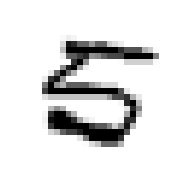

In [8]:
image_list[0].show()


### Split data

In [9]:
split_data = image_list.split_by_folder(train='training', valid='testing')

In [10]:
labeled_list = split_data.label_from_folder()


In [11]:
x,y = labeled_list.train[0]

5 torch.Size([1, 28, 28])


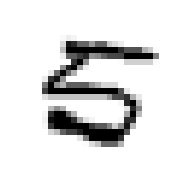

In [12]:
x.show()
print(y,x.shape)

### Transformations on the dataset

In [13]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [14]:
labeled_list = labeled_list.transform(tfms)


In [15]:
bs = 128


In [16]:
data = labeled_list.databunch(bs=bs).normalize()

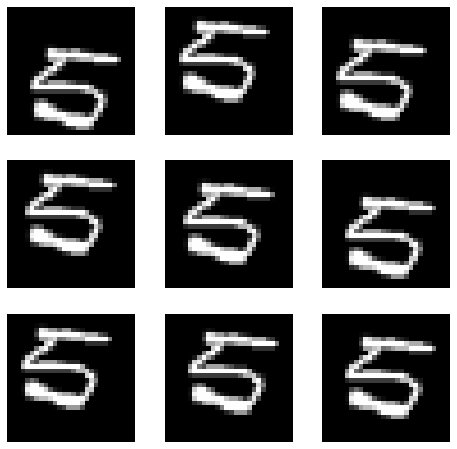

In [17]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

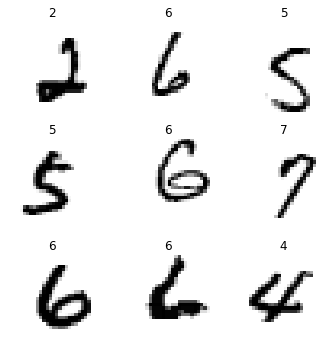

In [18]:
data.show_batch(rows=3, figsize=(5,5))


### Deep Learning Model

In [19]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [20]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [21]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)


In [22]:
print(learn.summary())


Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [23]:
xb,yb = data.one_batch()

In [24]:
xb = xb.cuda()


### Finding the best learning rate for the model

In [25]:
learn.lr_find(end_lr=100)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


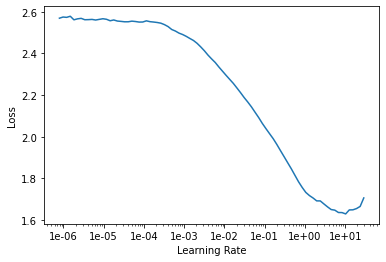

In [26]:
learn.recorder.plot()


### Best lr: 0.1

In [27]:
learn.fit_one_cycle(3, max_lr=0.1)


epoch,train_loss,valid_loss,accuracy,time
0,0.228491,0.192431,0.938600,00:37
1,0.130713,0.077182,0.975300,00:36
2,0.076986,0.039884,0.987000,00:36


### Using resnet blocks in the model architecture to further improve performance

In [31]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [32]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [33]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))


In [34]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [35]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


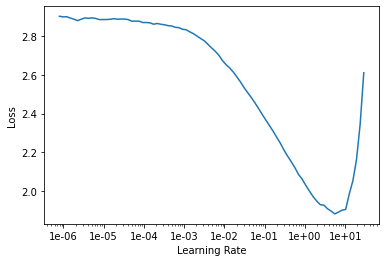

In [36]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(12, max_lr=0.05)


epoch,train_loss,valid_loss,accuracy,time
0,0.221587,0.124021,0.965000,00:41
1,0.133368,0.153192,0.953900,00:41
2,0.101583,0.221944,0.930000,00:41
3,0.083599,0.105433,0.966500,00:41
4,0.064434,0.074947,0.976300,00:41
5,0.059111,0.045058,0.986000,00:41
6,0.056453,0.030198,0.990800,00:41
7,0.041447,0.034342,0.988300,00:41
8,0.038394,0.026831,0.990900,00:41
9,0.023447,0.015897,0.994900,00:41


## Using resnet blocks, we got an accuracy of 99.6% in only 12 epochs.

In [38]:
print(learn.summary())


Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________